#### xG 슈팅의 골 기대값에 대한 시각화 자료입니다.
* 7개 대회에서 발생한 슈팅 데이터를 이용하여 선형 회귀 모델을 통해 슈팅 위치에 따른 골 기대값을 분석하였음

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from src.plot_utils import get_pitch_layout

shots = pd.read_pickle('data/shots.pkl')

보유한 대회 이벤트 데이트 기반 xG값을 학습합니다.
* src파일의 xgml.py 파일을 실행시켜 학습시킵니다,.
* 아래 코드를 실행시켜 주세요.

World_Cup : 100%|██████████| 64/64 [00:00<00:00, 387.18it/s]


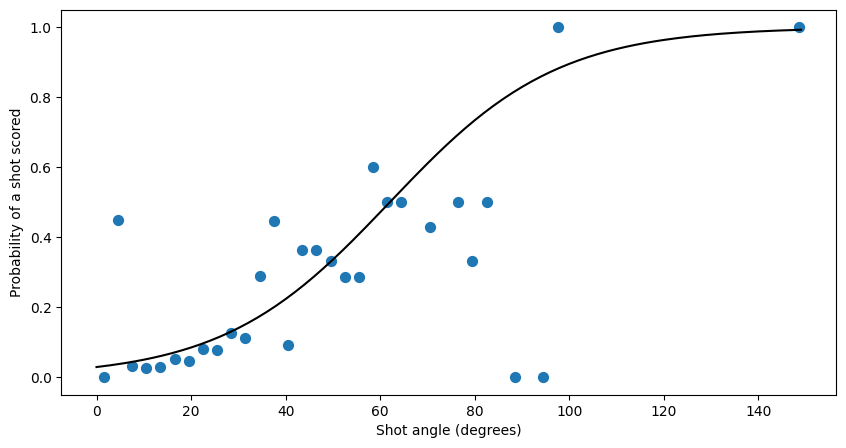

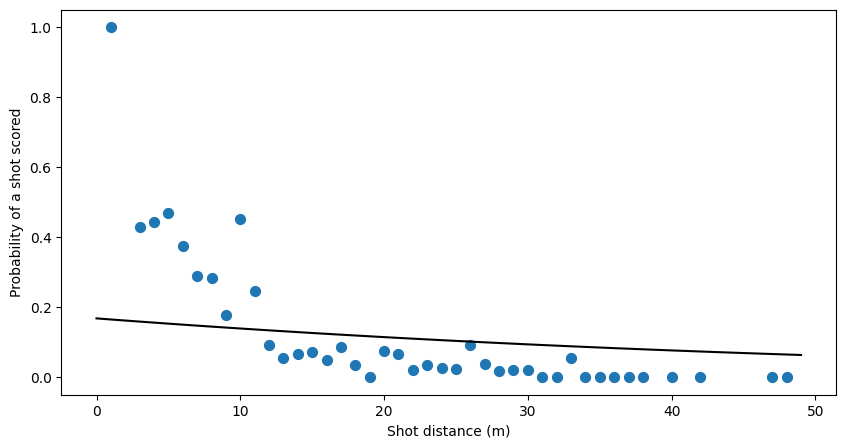

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 1573
Model:                            GLM   Df Residuals:                     1566
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -449.40
Date:                Sat, 09 Dec 2023   Deviance:                       898.80
Time:                        18:14:38   Pearson chi2:                 1.55e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1373
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9107      0.417    -11.782      0.0

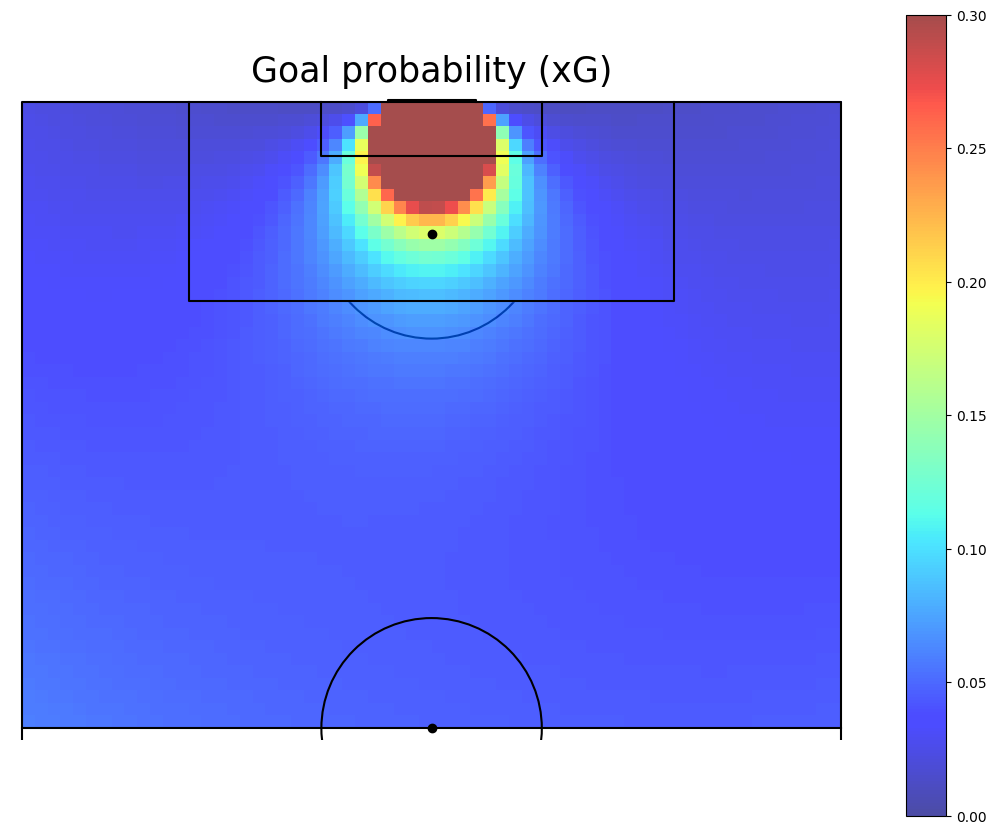

In [2]:
#머신러닝 파일 코드
import sys
sys.path.insert(0, '.')
import xgml


분석을 희망하는 경기의 match_id를 할당해주세요
* 분석 희망 데이터 찾기.ipynb를 통해 원하는 경기의 match_id를 찾을 수 있습니다.

In [3]:
match_id = 2057987

아래 코드를 실행시키시면, 원하는 경기에서 발생한 슈팅에 대한 시각화 결과를 보실 수 있습니다.
* 팀 컬러가 채워진 도형은 골로 연결된 슈팅입니다.
* 각 도형에 대해 마우스를 올려두면 상세 정보 확인이 가능합니다.
* 사각형의 경우 패널트킥, 프리킥을 의미합니다.

In [4]:
match_df = pd.read_csv('data/refined_events/World_Cup/matches.csv', index_col=0, header=0, encoding='utf-8-sig')
team1_name = match_df.at[match_id, 'team1_name']
team2_name = match_df.at[match_id, 'team2_name']

match_shots = shots[shots['match_id'] == match_id]
match_shots['display_name'] = match_shots.apply(
    lambda x: f"{x['player_name']}, " +
    f"{x['period']} {int(x['time'] // 60):02d}:{int(x['time'] % 60):02d}, " +
    f"xG: {round(x['xg'], 3)}", axis=1
)

team2_x = match_shots.loc[match_shots['team_name'] == team2_name, 'x']
team1_y = match_shots.loc[match_shots['team_name'] == team1_name, 'y']
team2_y = match_shots.loc[match_shots['team_name'] == team2_name, 'y']
match_shots.loc[match_shots['team_name'] == team2_name, 'x'] = 104 - team2_x
match_shots.loc[match_shots['team_name'] == team1_name, 'y'] = 34 - team1_y
match_shots.loc[match_shots['team_name'] == team2_name, 'y'] = 34 + team2_y

match_shots_failed = match_shots[match_shots['tags'].apply(lambda x: 'Goal' not in x)]

team1_shots = match_shots[match_shots['team_name'] == team1_name]
team2_shots = match_shots[match_shots['team_name'] == team2_name]
team1_goals = team1_shots[team1_shots['tags'].apply(lambda x: 'Goal' in x)]
team2_goals = team2_shots[team2_shots['tags'].apply(lambda x: 'Goal' in x)]

team1_goal_trace = go.Scatter(
    x=team1_goals['x'],
    y=team1_goals['y'],
    name=team1_name,
    text=team1_goals['display_name'],
    mode='markers',
    marker=dict(
        color='red', size=np.sqrt(team1_goals['xg']) * 50, 
        symbol=team1_goals['freekick'].apply(lambda x: 'square' if x == 1 else 'circle')
    )
)

team2_goal_trace = go.Scatter(
    x=team2_goals['x'],
    y=team2_goals['y'],
    name=team2_name,
    text=team2_goals['display_name'],
    mode='markers',
    marker=dict(
        color='blue', size=np.sqrt(team2_goals['xg']) * 50, 
        symbol=team2_goals['freekick'].apply(lambda x: 'square' if x == 1 else 'circle')
    )
)

shot_trace = go.Scatter(
    x=match_shots_failed['x'],
    y=match_shots_failed['y'],
    name='Failed shot',
    text=match_shots_failed['display_name'],
    mode='markers',
    marker=dict(
        color='darkgrey', size=np.sqrt(match_shots_failed['xg']) * 50, 
        symbol=match_shots_failed['freekick'].apply(lambda x: 'square' if x == 1 else 'circle')
    )
)

team1_xg = team1_shots['xg'].sum().round(2)
team2_xg = team2_shots['xg'].sum().round(2)
title = f"{team1_name} - {team2_name} (xG: {team1_xg} - {team2_xg})"
fig = go.Figure(data=[shot_trace, team1_goal_trace, team2_goal_trace], layout=get_pitch_layout(title))
fig.show()